In [1]:
%load_ext autoreload

%autoreload 2
import sys
import pyccl as ccl
import numpy as np
from clmm import Cosmology
from multiprocessing import Pool
import matplotlib.pyplot as plt
import emcee
import time
import pickle
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/cluster_abundance')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_modeling_richness_mass_relation as rm_relation

import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import analysis_Mass_Richness_relation as analysis

In [2]:
#cosmology
Omega_m_true = 0.2648
Omega_b_true = 0.0448
Omega_c_true = Omega_m_true - Omega_b_true
sigma8_true = 0.8
H0_true = 71
ns_true = 0.963
True_value = [Omega_m_true, sigma8_true]
cosmo_clmm = Cosmology(H0 = H0_true, Omega_dm0 = Omega_c_true, Omega_b0 = Omega_b_true, Omega_k0 = 0.0)
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = H0_true/100, sigma8 = sigma8_true, n_s=ns_true)
#halo model
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef,)#hydro=False)
#purity
a_nc, b_nc, a_rc, b_rc = np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592
theta_purity = [a_nc, b_nc, a_rc, b_rc]
#completeness
a_nc, b_nc, a_mc, b_mc = 1.1321, 0.7751, 13.31, 0.2025
theta_completeness = [a_nc, b_nc, a_mc, b_mc]
#rm_relation
log10m0, z0 = np.log10(10**14.2), .4
proxy_mu0, proxy_muz, proxy_mulog10m =  3.091, 0, 1.05*np.log(10)
#proxy_mu0, proxy_muz, proxy_mulog10m =3.50831009, -0.04283462 , 2.20183355
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.594, 0., 0.026*np.log(10)
#proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m = 0.24189878,  0.74964302,  0.55467301
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

richness_grid = np.exp(np.linspace(np.log(20), np.log(200), 200))
logm_grid = np.linspace(12, 15,200)
z_grid = np.linspace(.2, 1, 102)

In [3]:
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 'compute_completeness':True, 'compute_purity':True }

count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

data = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_true.pkl', allow_pickle=True)
profiles = data['stacked profile']
covariances = data['stacked covariance']
r = profiles['radius'][0]

#cluster_lensing = np.zeros([len(r), len(logm_grid), len(z_grid)])#
cluster_lensing = cl_lensing.compute_cluster_lensing(r, 'Diemer15', logm_grid, z_grid, cosmo, cosmo_clmm)

Z_bin = analysis.Z_bin
Richness_bin = analysis.Obs_bin
print(Z_bin)
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
DS_obs = np.zeros([len(r), len(Richness_bin), len(Z_bin)])
Err_obs = np.zeros([len(r), len(Richness_bin), len(Z_bin)])

for i, z_bin in enumerate(Z_bin):
    mask_z = (profiles['z_mean'] > z_bin[0])*(profiles['z_mean'] < z_bin[1])
    for j, richness_bin in enumerate(Richness_bin):
        mask_richness = (profiles['obs_mean'] > richness_bin[0])*(profiles['obs_mean'] < richness_bin[1])
        mask_tot = mask_z * mask_richness
        DS_obs[:,j,i] = profiles['gt'][mask_tot][0]
        Err_obs[:,j,i] = covariances['cov_t'][mask_tot][0].diagonal()**.5

[[0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 1.0]]


In [4]:
r

array([0.55714842, 0.6804306 , 0.83032523, 1.01419232, 1.23822211,
       1.51217248, 1.84672312, 2.25518907, 2.75257284, 3.3614032 ,
       4.10456528, 5.01139196, 6.11925852, 7.47073947, 9.12433179])

In [5]:
Omegaredmapper = 439.78987
Omega = 4*np.pi*(Omegaredmapper/(360**2/np.pi))

In [6]:
def DS(params, purity, completeness):
    
    proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m, Om, s8 = params
    theta_rm_new = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
    cosmo_new = ccl.Cosmology(Omega_c = Om - Omega_b_true, Omega_b = Omega_b_true, h = H0_true/100, sigma8 = s8, n_s=ns_true)
    massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
    hmd = ccl.halos.hmfunc.MassFuncBocquet16(cosmo_new, mass_def=massdef,hydro=False)
    params_new = {'params_purity':theta_purity, 
                  'params_completeness': theta_completeness, 
                  'params_richness_mass_relation': theta_rm_new,
                  'CCL_cosmology': cosmo_new, 
                  'halo_mass_distribution': hmd}
    compute_new = {'compute_dNdzdlogMdOmega':True,
                   'compute_richness_mass_relation':True, 
                   'compute_completeness':False, 
                   'compute_purity':False}
    adds_N = {'add_purity':purity, 'add_completeness':completeness}
    adds_NDS = {'add_purity':False, 'add_completeness':True}
    count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute_new, params = params_new)
    integrand_count_new = cl_count.define_count_integrand(count_modelling_new, adds_N)
    integrand_count_ds_new = cl_count.define_count_integrand(count_modelling_new, adds_NDS)
    NDS_profiles = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count_ds_new, 
                                                                      cluster_lensing = cluster_lensing, 
                                                                      lensing_radius = r, grids = grids)
    N = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count_new, grids = grids)
    DS_profiles = NDS_profiles/N
    lnL = -.5*np.sum(((DS_profiles - DS_obs)/Err_obs)**2)
    return N, DS_profiles,integrand_count_new, integrand_count_ds_new

In [17]:
tWLN = np.load('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/richness_mass_from_DC2/chains/manuscript_analysis_WLxN_.pkl', allow_pickle = True)
params_new_tWLN = list(np.mean(tWLN[17000:], axis=0))
params_new_tWLN.append(Omega_m_true)
params_new_tWLN.append(sigma8_true)
print(params_new_tWLN)
tWLN_cosmo = np.load('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/richness_mass_from_DC2/chains/manuscript_analysis_WLxN_fit_cosmo.pkl', allow_pickle = True)
params_new_tWLN_cosmo = list(np.mean(tWLN_cosmo[17000:], axis=0))
tfiducial = np.load('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/richness_mass_from_DC2/plots/fiducial.pkl.npy')
params_new_fid = list(np.mean(tfiducial, axis=0))
params_new_fid.append(Omega_m_true)
params_new_fid.append(sigma8_true)

[2.9817896758618043, -0.35170569795647433, 2.264991901203766, 0.5907369059465924, 0.37331616810114854, -0.01114777464623889, 0.2648, 0.8]


In [18]:
params_new_tWLN_cosmo

[3.1219242909501927,
 -0.23407331644849802,
 2.3374231319510486,
 0.5079838792618727,
 0.4256731506356477,
 0.04514161908351878,
 0.26563741946455305,
 0.7822347190376411]

In [16]:
params_new_tWLN

[3.4495108720126013,
 0.004256996704585974,
 2.301561321748246,
 0.3276791645957994,
 0.3265677128171295,
 0.19116059671497923,
 0.2648,
 0.8]

In [10]:
table_redmapper = load('catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl')
N_obs, proxy_edges, z_edges = np.histogram2d(table_redmapper['richness'],table_redmapper['redshift'], 
                                                       
                                                   bins=[analysis.rich_corner, analysis.z_corner,])

In [20]:
N_mod_pnc, DS_mod, int_count, int_ds_count = DS(params_new_tWLN, False, True)
N_mod_npc, DS_mod,int_count, int_ds_count = DS(params_new_tWLN, True, False)
N_mod_pc, DS_mod,int_count, int_ds_count = DS(params_new_tWLN, False, False)
N_mod_npnc, DS_mod,int_count, int_ds_count = DS(params_new_tWLN, True, True)
Nfid, DS_mod, int_count, int_ds_count  = DS(params_new_fid, True, True)

In [21]:
N_mod_pnc_cosmo, DS_mod, int_count, int_ds_count = DS(params_new_tWLN_cosmo, False, True)
N_mod_npc_cosmo, DS_mod,int_count, int_ds_count = DS(params_new_tWLN_cosmo, True, False)
N_mod_pc_cosmo, DS_mod,int_count, int_ds_count = DS(params_new_tWLN_cosmo, False, False)
N_mod_npnc_cosmo, DS_mod,int_count, int_ds_count = DS(params_new_tWLN_cosmo, True, True)

In [22]:
np.save( 'best_fit_DS',DS_mod,)

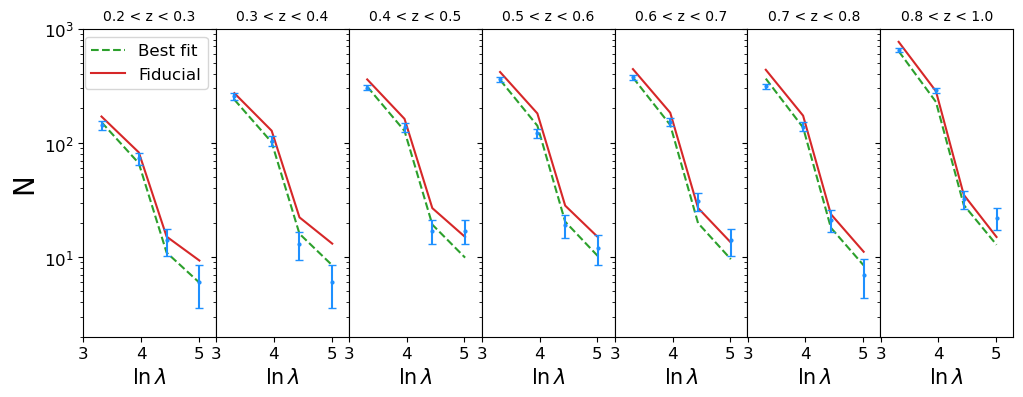

In [23]:
c = ['k', 'k', 'k', 'k', 'k', 'k', 'k']
indexes = [0,7]
#indexes = [3, 7]
fig, ax = plt.subplots(1, len(Z_bin[indexes[0]:indexes[1]]), figsize=(12,4), sharex = True, sharey = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

for i, z_bin in enumerate(analysis.Z_bin[indexes[0]:indexes[1]]):
    z0 = z_bin[0]
    z1 = z_bin[1]
    #ax[i].set_box_aspect(1)
    ax[i].set_title(f'{z0:.1f} < z < {z1:.1f}', fontsize=10)
    #ax[i].plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_pnc[:,i], ls = '-', label = r'$p=1, c\neq 1$', color = 'C1')
    #ax[i].plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_npc[:,i], ls='-', label = r'$p\neq 1, c= 1$', color = 'magenta')
    #ax[i].plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_npnc[:,i], ls=(0, (2, 5)),  label = r'$p\neq 1, c\neq 1$', color = 'C2')
    ax[i].plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_npnc_cosmo[:,i], ls='--',  label = r'Best fit', color = 'C2')
    #ax[i].plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_pc[:,i], ls='-', label=r'$p=1, c=1$', color = 'C0')
    ax[i].plot(np.log(np.mean(analysis.Obs_bin, axis=1)), Nfid[:,i],   '-C3', label = 'Fiducial')
    ax[i].errorbar(np.log(np.mean(analysis.Obs_bin, axis=1)), N_obs[:,i],  N_obs[:,i]**.5,  color = 'dodgerblue', marker = 'o', markersize=2, fmt=' ', capsize=3)
    #ax[i].stairs(N_obs[:,i], np.log(analysis.rich_corner))
  
    ax[i].set_xlabel(r'$\ln \lambda$', fontsize=15)
    ax[0].set_ylabel('N', fontsize=20)
    ax[0].legend(fontsize=12, frameon=True,ncols=1, loc = 'upper right')
   # ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim(2, 1e3)
    ax[i].set_xlim(np.log(20), np.log(200))
    ax[i].tick_params(axis='both', which="both", labelsize= 12)
plt.savefig('abundance_redmapper_best_fit.png', bbox_inches='tight', dpi=300)

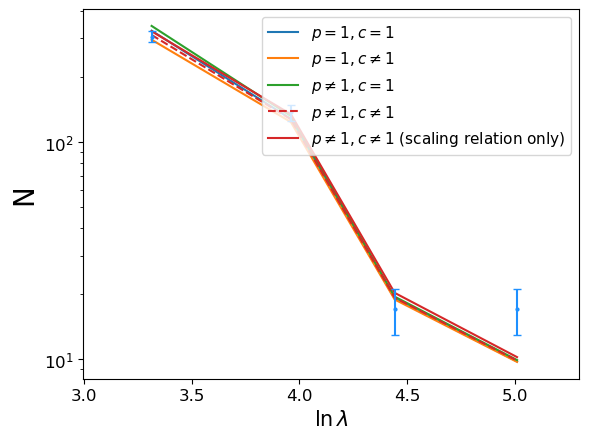

In [29]:
c = ['k', 'k', 'k', 'k', 'k', 'k', 'k']
indexes = [0,1]
indexes = [3, 1]
#fig, ax = plt.subplots(1, len(Z_bin[indexes[0]:indexes[1]]), figsize=(12,7), sharex = True, sharey = True)
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=None)
i = 2
plt.plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_pc_cosmo[:,i], ls='-', label=r'$p=1, c=1$', color = 'C0')
plt.plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_pnc_cosmo[:,i], ls = '-', label = r'$p=1, c\neq 1$', color = 'C1')
plt.plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_npc_cosmo[:,i], ls='-', label = r'$p\neq 1, c= 1$', color = 'C2')
plt.plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_npnc_cosmo[:,i], ls='--',  label = r'$p\neq 1, c\neq 1$', color = 'C3')
#plt.plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_npnc_cosmo[:,i], ls='--',  label = r'$p\neq 1, c\neq 1$', color = 'C2')
plt.plot(np.log(np.mean(analysis.Obs_bin, axis=1)), N_mod_npnc[:,i], ls='-', label=r'$p\neq 1, c\neq 1$ (scaling relation only)', color = 'C3')
#p#lt.plot(np.log(np.mean(analysis.Obs_bin, axis=1)), Nfid[:,i],   '-C3', label = 'Fiducial')
plt.errorbar(np.log(np.mean(analysis.Obs_bin, axis=1)), N_obs[:,i],  N_obs[:,i]**.5,  color = 'dodgerblue', marker = 'o', markersize=2, fmt=' ', capsize=3)
#ax[i].stairs(N_obs[:,i], np.log(analysis.rich_corner))

plt.xlabel(r'$\ln \lambda$', fontsize=15)
plt.ylabel('N', fontsize=20)
plt.legend(fontsize=11, frameon=True,ncols=1, loc = 'upper right')
# ax[i].set_xscale('log')
plt.yscale('log')
#plt.ylim(2, 5e3)
plt.xlim(np.log(20), np.log(200))
plt.tick_params(axis='both', which="both", labelsize= 12)
#plt.savefig('abundance_redmapper_modeling.png', bbox_inches='tight', dpi=300)